In [ ]:
#below is the forcasting method

In [4]:
import pandas as pd
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import re  # Importing regular expressions
from sklearn.metrics import mean_squared_error  # Importing MSE from sklearn

# Step 1: Load the dataset
print("Loading the dataset...")
data = pd.read_csv("['EGLL']_2023-04-01_00-00-00_till_2024-03-31_00-00-00_stack_cleaned_RECAT.csv")
data=data.drop(columns=['WTC L', 'WTC M', 'WTC H','WTC J'])
# Ensure the timestamp is in datetime format and set as index
print("Converting timestamps and setting index...")
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Step 2: Clean initial column names to remove spaces or special characters
data.columns = [re.sub(r'\W+', '_', col) for col in data.columns]
print("\nCleaned Column Names:")
print(data.columns)

# Check if frequency is missing and set it explicitly
if data.index.freq is None:
    print("Frequency is not set. Attempting to set it...")
    try:
        data = data.asfreq('15min', method='pad')  # Adjust '15min' to your actual time interval
        print(f"Frequency set to: {data.index.freq}")
    except Exception as e:
        print(f"Error setting frequency: {e}")

# Step 2: Prepare the data
print("Preparing the data...")
holding_columns = ['Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov', 'Holding_Time_Lam']

# Handle missing values by dropping rows with NaNs in target columns
print("Dropping rows with NaN values in target columns...")
data.dropna(subset=holding_columns, inplace=True)

# Split data into training and testing sets using train_test_split
print("Splitting data into training and testing sets...")
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

Loading the dataset...
Converting timestamps and setting index...

Cleaned Column Names:
Index(['Unnamed_0', 'Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov',
       'Holding_Time_Lam', 'Big', 'Ock', 'Bov', 'Lam', 'Decimal_Hours', 'day',
       'month', 'year', 'day_of_week', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Big_Max', 'Big_Min', 'Ock_Max', 'Ock_Min',
       'Bov_Max', 'Bov_Min', 'Lam_Max', 'Lam_Min', 'RECAT_EU_A', 'RECAT_EU_B',
       'RECAT_EU_C', 'RECAT_EU_D', 'RECAT_EU_E', 'RECAT_EU_F', 'Engine_Jet',
       'Engine_Turboprop_shaft', 'Runway_09L', 'Runway_09R', 'Runway_27L',
       'Runway_27R', 'No_of_Landings_1HR', 'No_stack', 'ceiling', 'wind',
       'precip', 'freezing', 'phenomena', 'wind_dir', 'wind_speed',
       'Crosswind_Component', 'Headwind_Component', 'departures_delayIndex',
       'arrivals_numCancelled', 'arrivals_delayIndex'],
      dtype='object')
Frequency is not set. Attempting to set it...
Frequency set to: <15 * M

In [5]:
# Step 3: Define the forecaster and grid search functions

# Function to create a forecaster
def create_forecaster(window_length=5):
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=window_length, strategy="recursive")
    return forecaster

# Function to perform grid search and forecast
def grid_search_forecaster(train, test, target_column, param_grid):
    print(f"Creating forecaster for {target_column}...")
    forecaster = create_forecaster()

    # Cross-validation setup
    print(f"Setting up cross-validation for {target_column}...")
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))

    # Grid search
    print(f"Starting grid search for {target_column}...")
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )

    # Fit the model
    print(f"Fitting the model for {target_column}...")
    gscv.fit(train[target_column])
    print(f"Best params for {target_column}: {gscv.best_params_}")

    # Forecasting
    print(f"Forecasting for {target_column}...")
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    
    # Calculate performance metrics
    print(f"Calculating performance metrics for {target_column}...")
    mae = np.mean(np.abs(test[target_column] - y_pred))
    mape = MeanAbsolutePercentageError(symmetric=True)(test[target_column], y_pred)
    mse = mean_squared_error(test[target_column], y_pred)  # MSE calculation

    print(f"MAE for {target_column}: {mae}")
    print(f"MAPE for {target_column}: {mape}")
    print(f"MSE for {target_column}: {mse}")  # Print the MSE

    return mae, mape, mse, y_pred, gscv.best_params_

# Step 4: Perform grid search for each holding column

# Define the parameter grid for window length
param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30]  # Grid search over these window lengths
}

# Dictionary to store results
results = {}

print("Starting grid search for each holding column...")
for column in holding_columns:
    print(f"\nProcessing column: {column}")
    mae, mape, mse, predictions, best_params = grid_search_forecaster(train_data, test_data, column, param_grid)
    results[column] = {"MAE": mae, "MAPE": mape, "MSE": mse, "Predictions": predictions, "Best_Window_Length": best_params["window_length"]}

# Step 5: Forecast for multiple time steps into the future

# Define the future intervals (15-minute steps for 4 hours)
future_intervals = np.arange(1, 17)  # 16 intervals (15, 30, ..., 240 minutes)

# Dictionary to store future predictions
future_predictions = {}

print("\nStarting future predictions for each holding column...")
for column in holding_columns:
    print(f"Forecasting future intervals for {column}...")
    # Use the best forecaster found during grid search
    best_forecaster = create_forecaster(window_length=results[column]["Best_Window_Length"])
    best_forecaster.fit(train_data[column])
    
    # Predict future intervals
    future_pred = best_forecaster.predict(fh=future_intervals)
    future_predictions[column] = future_pred

# Step 6: Display the future predictions
for column in holding_columns:
    print(f"\nFuture predictions for {column}:")
    print(future_predictions[column])

print("\nProcess completed successfully.")

Starting grid search for each holding column...

Processing column: Holding_Time_Big
Creating forecaster for Holding_Time_Big...
Setting up cross-validation for Holding_Time_Big...
Starting grid search for Holding_Time_Big...
Fitting the model for Holding_Time_Big...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 1.429268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from

Loading the dataset...
Converting timestamps and setting index...

Cleaned Column Names:
Index(['Unnamed_0', 'Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov',
       'Holding_Time_Lam', 'Big', 'Ock', 'Bov', 'Lam', 'Decimal_Hours', 'day',
       'month', 'year', 'day_of_week', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Big_Max', 'Big_Min', 'Ock_Max', 'Ock_Min',
       'Bov_Max', 'Bov_Min', 'Lam_Max', 'Lam_Min', 'RECAT_EU_A', 'RECAT_EU_B',
       'RECAT_EU_C', 'RECAT_EU_D', 'RECAT_EU_E', 'RECAT_EU_F', 'Engine_Jet',
       'Engine_Turboprop_shaft', 'Runway_09L', 'Runway_09R', 'Runway_27L',
       'Runway_27R', 'No_of_Landings_1HR', 'No_stack', 'ceiling', 'wind',
       'precip', 'freezing', 'phenomena', 'wind_dir', 'wind_speed',
       'Crosswind_Component', 'Headwind_Component', 'departures_delayIndex',
       'arrivals_numCancelled', 'arrivals_delayIndex'],
      dtype='object')
Frequency is not set. Attempting to set it...
Frequency set to: <15 * M

 98%|===================| 27530/28108 [00:32<00:00]        

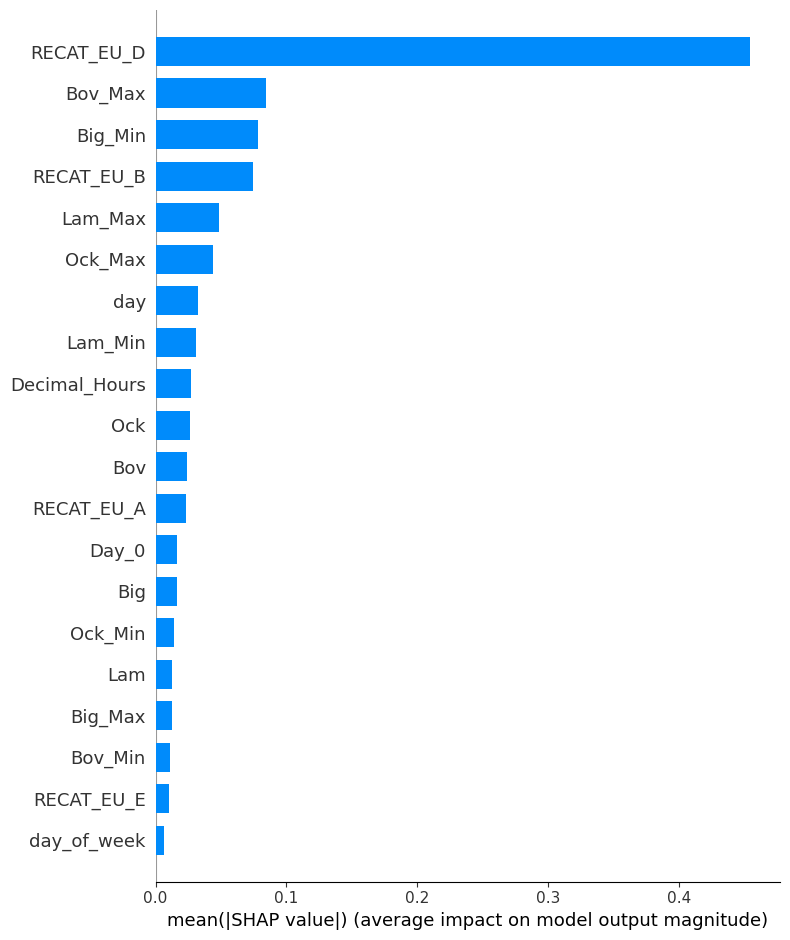

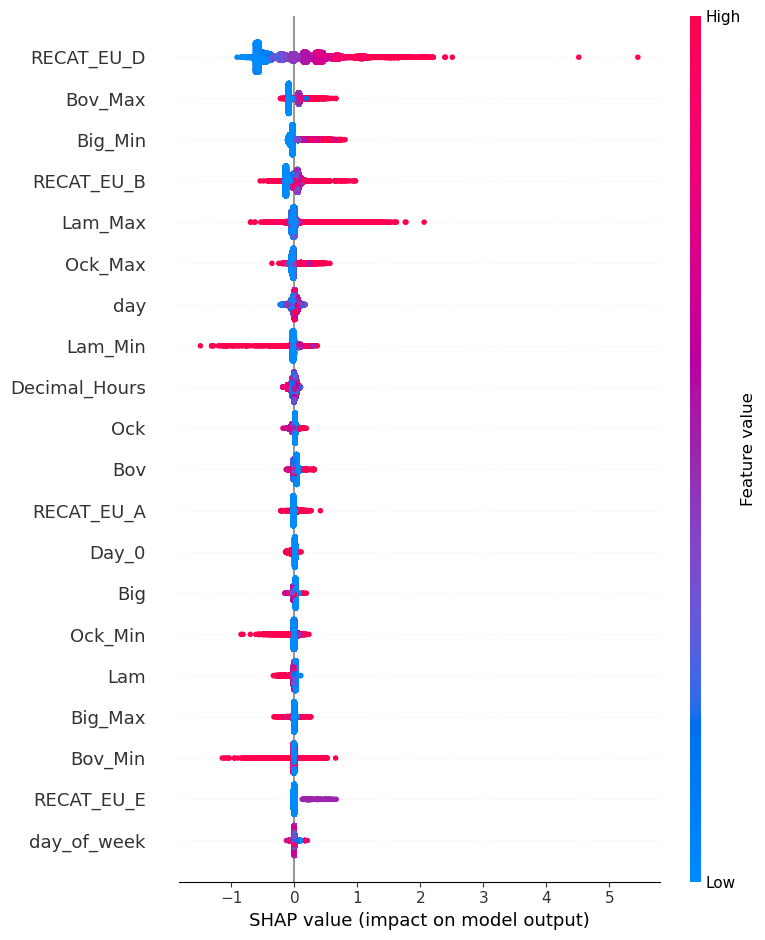


Processing column: Holding_Time_Ock
Creating forecaster for Holding_Time_Ock...
Setting up cross-validation for Holding_Time_Ock...
Starting grid search for Holding_Time_Ock...
Fitting the model for Holding_Time_Ock...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Start training from score 1.373197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Sta

 98%|===================| 27531/28108 [00:41<00:00]        

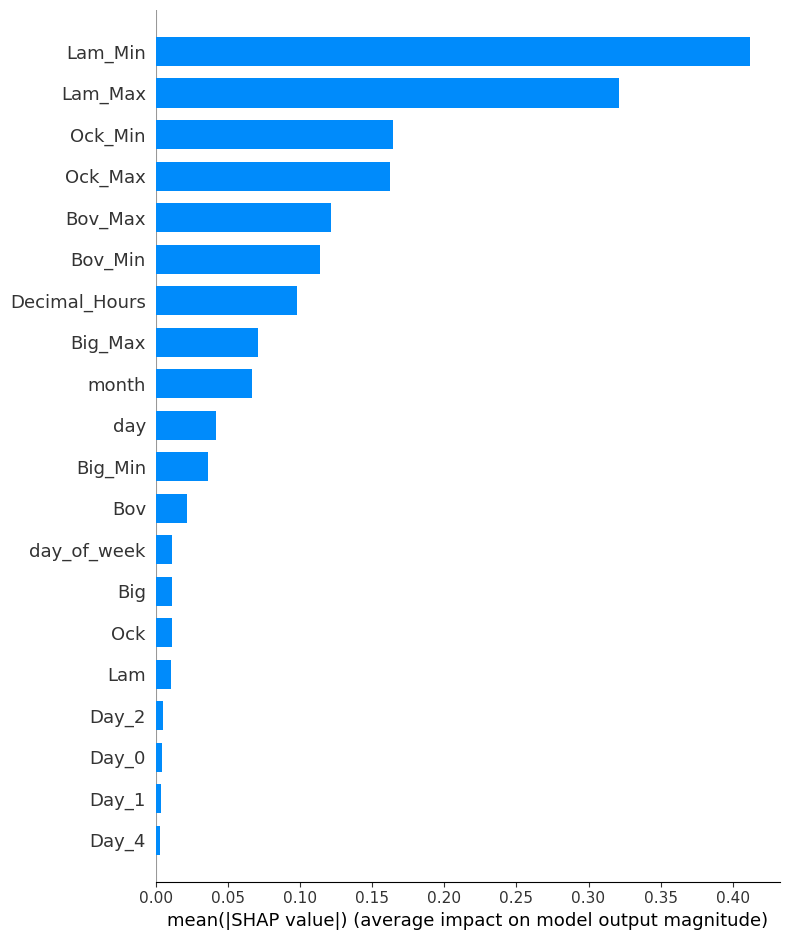

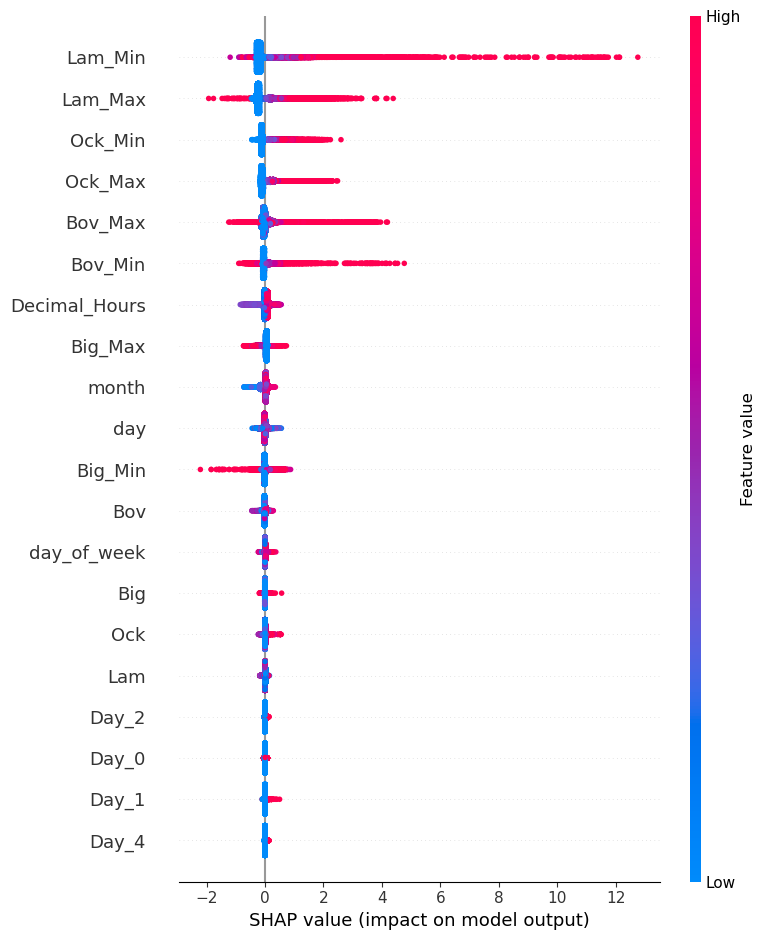


Processing column: Holding_Time_Bov
Creating forecaster for Holding_Time_Bov...
Setting up cross-validation for Holding_Time_Bov...
Starting grid search for Holding_Time_Bov...
Fitting the model for Holding_Time_Bov...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 2.571818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Sta

 97%|=================== | 27303/28108 [00:29<00:00]       

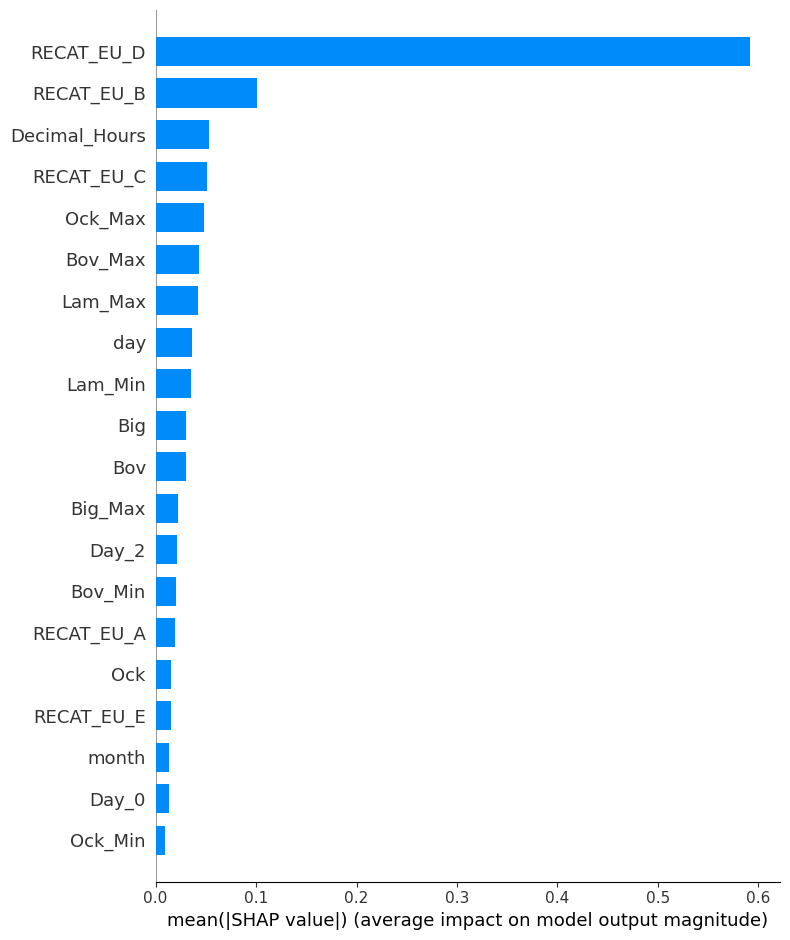

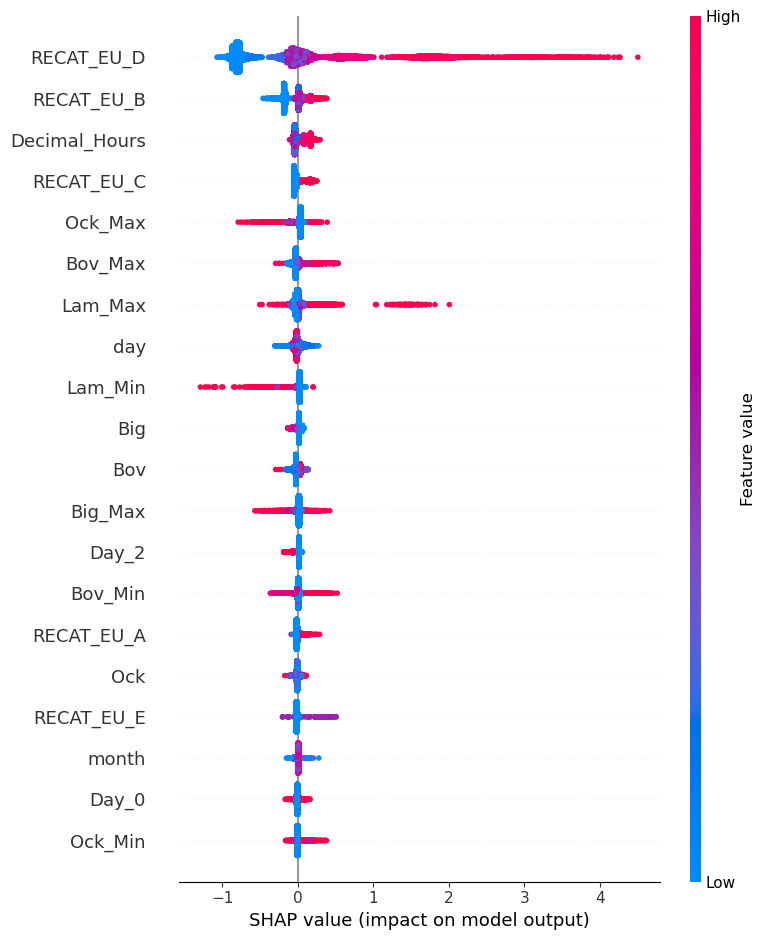


Processing column: Holding_Time_Lam
Creating forecaster for Holding_Time_Lam...
Setting up cross-validation for Holding_Time_Lam...
Starting grid search for Holding_Time_Lam...
Fitting the model for Holding_Time_Lam...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 1.545356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Sta

 99%|===================| 27816/28108 [00:36<00:00]        

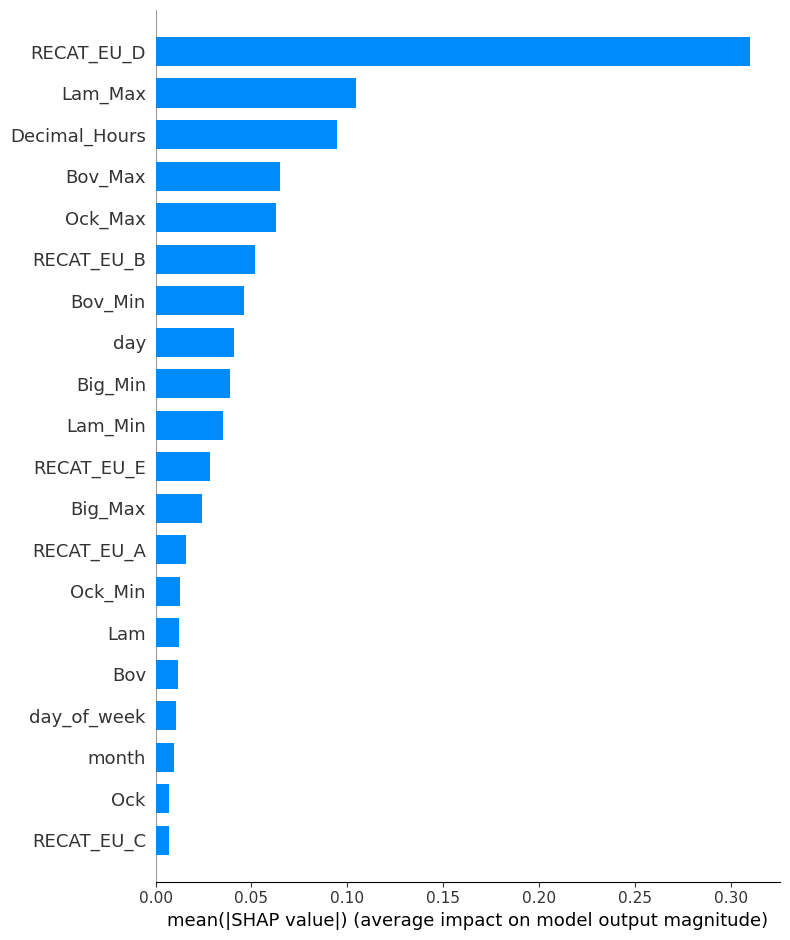

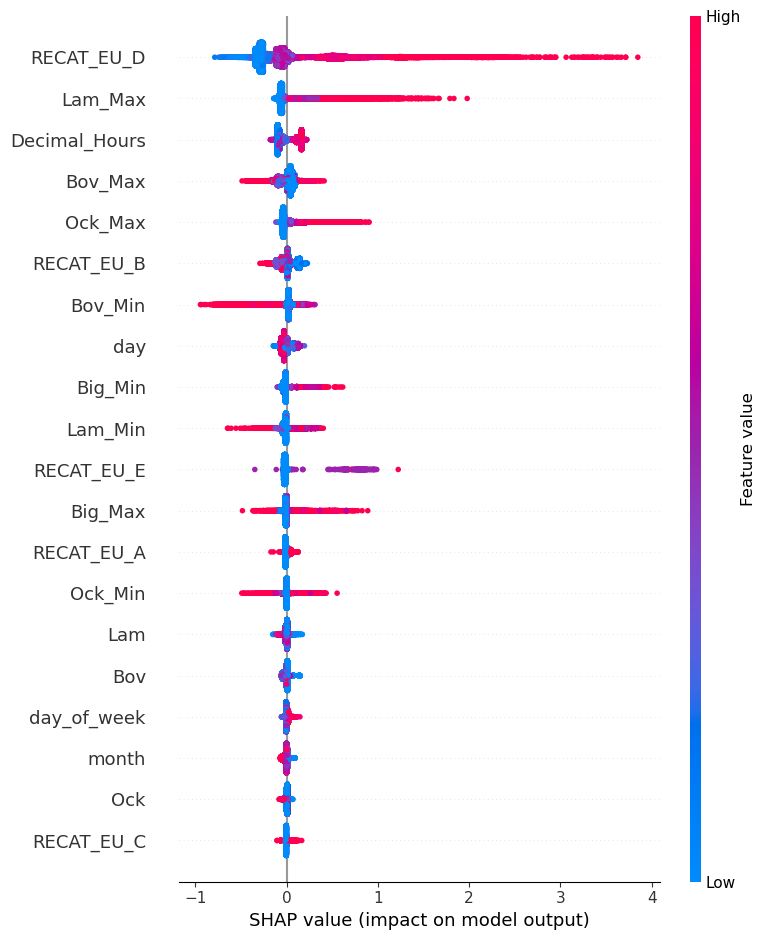


Starting future predictions for each holding column...
Forecasting future intervals for Holding_Time_Big...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 1.429268
Forecasting future intervals for Holding_Time_Ock...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Start training from score 1.373197
Forecasting future interva

In [22]:
import pandas as pd
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_squared_error
import shap  # Import SHAP library

# Step 1: Load the dataset
print("Loading the dataset...")
data = pd.read_csv("['EGLL']_2023-04-01_00-00-00_till_2024-03-31_00-00-00_stack_cleaned_RECAT.csv")
data = data.drop(columns=['WTC L', 'WTC M', 'WTC H', 'WTC J'])

# Ensure the timestamp is in datetime format and set as index
print("Converting timestamps and setting index...")
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Step 2: Clean initial column names to remove spaces or special characters
data.columns = [re.sub(r'\W+', '_', col) for col in data.columns]
print("\nCleaned Column Names:")
print(data.columns)

# Check if frequency is missing and set it explicitly
if data.index.freq is None:
    print("Frequency is not set. Attempting to set it...")
    try:
        data = data.asfreq('15min', method='pad')  # Adjust '15min' to your actual time interval
        print(f"Frequency set to: {data.index.freq}")
    except Exception as e:
        print(f"Error setting frequency: {e}")

# Step 3: Prepare the data
print("Preparing the data...")
holding_columns = ['Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov', 'Holding_Time_Lam']

# Handle missing values by dropping rows with NaNs in target columns
print("Dropping rows with NaN values in target columns...")
data.dropna(subset=holding_columns, inplace=True)

# Split data into training and testing sets using train_test_split
print("Splitting data into training and testing sets...")
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Step 4: Define the forecaster and grid search functions

# Function to create a forecaster
def create_forecaster(window_length=5):
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=window_length, strategy="recursive")
    return forecaster

# Function to perform SHAP analysis
def shap_analysis(model, train_data, feature_names):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, train_data[feature_names])
    
    # Calculate SHAP values
    shap_values = explainer(train_data[feature_names])
    
    # Plot the beeswarm plot
    shap.summary_plot(shap_values, train_data[feature_names], plot_type="bar")
    shap.summary_plot(shap_values, train_data[feature_names])

# Function to perform grid search and forecast
def grid_search_forecaster(train, test, target_column, param_grid):
    print(f"Creating forecaster for {target_column}...")
    forecaster = create_forecaster()

    # Cross-validation setup
    print(f"Setting up cross-validation for {target_column}...")
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))

    # Grid search
    print(f"Starting grid search for {target_column}...")
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )

    # Fit the model
    print(f"Fitting the model for {target_column}...")
    gscv.fit(train[target_column])
    print(f"Best params for {target_column}: {gscv.best_params_}")

    # Forecasting
    print(f"Forecasting for {target_column}...")
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    
    # Calculate performance metrics
    print(f"Calculating performance metrics for {target_column}...")
    mae = np.mean(np.abs(test[target_column] - y_pred))
    mape = MeanAbsolutePercentageError(symmetric=True)(test[target_column], y_pred)
    mse = mean_squared_error(test[target_column], y_pred)  # MSE calculation

    print(f"MAE for {target_column}: {mae}")
    print(f"MAPE for {target_column}: {mape}")
    print(f"MSE for {target_column}: {mse}")  # Print the MSE

    # Perform SHAP analysis
    print(f"Performing SHAP analysis for {target_column}...")
    feature_names = train.columns.drop(holding_columns)  # Assuming holding_columns are your target columns
    
    # Access the underlying regressor from the forecaster
    regressor = gscv.best_forecaster_.estimator_
    shap_analysis(regressor, train, feature_names)  # Perform SHAP analysis on the regressor

    return mae, mape, mse, y_pred, gscv.best_params_

# Step 5: Perform grid search for each holding column

# Define the parameter grid for window length
param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30]  # Grid search over these window lengths
}

# Dictionary to store results
results = {}

print("Starting grid search for each holding column...")
for column in holding_columns:
    print(f"\nProcessing column: {column}")
    mae, mape, mse, predictions, best_params = grid_search_forecaster(train_data, test_data, column, param_grid)
    results[column] = {"MAE": mae, "MAPE": mape, "MSE": mse, "Predictions": predictions, "Best_Window_Length": best_params["window_length"]}

# Step 6: Forecast for multiple time steps into the future

# Define the future intervals (15-minute steps for 4 hours)
future_intervals = np.arange(1, 17)  # 16 intervals (15, 30, ..., 240 minutes)

# Dictionary to store future predictions
future_predictions = {}

print("\nStarting future predictions for each holding column...")
for column in holding_columns:
    print(f"Forecasting future intervals for {column}...")
    # Use the best forecaster found during grid search
    best_forecaster = create_forecaster(window_length=results[column]["Best_Window_Length"])
    best_forecaster.fit(train_data[column])
    
    # Predict future intervals
    future_pred = best_forecaster.predict(fh=future_intervals)
    future_predictions[column] = future_pred

# Step 7: Display the future predictions
for column in holding_columns:
    print(f"\nFuture predictions for {column}:")
    print(future_predictions[column])

print("\nProcess completed successfully.")

In [24]:
import pandas as pd
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_squared_error
import shap  # Import SHAP library
import matplotlib.pyplot as plt  # Import matplotlib for saving plots

# Step 1: Load the dataset
print("Loading the dataset...")
data = pd.read_csv("['EGLL']_2023-04-01_00-00-00_till_2024-03-31_00-00-00_stack_cleaned_RECAT.csv")
data = data.drop(columns=['WTC L', 'WTC M', 'WTC H', 'WTC J'])

# Ensure the timestamp is in datetime format and set as index
print("Converting timestamps and setting index...")
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Step 2: Clean initial column names to remove spaces or special characters
data.columns = [re.sub(r'\W+', '_', col) for col in data.columns]
print("\nCleaned Column Names:")
print(data.columns)

# Check if frequency is missing and set it explicitly
if data.index.freq is None:
    print("Frequency is not set. Attempting to set it...")
    try:
        data = data.asfreq('15min', method='pad')  # Adjust '15min' to your actual time interval
        print(f"Frequency set to: {data.index.freq}")
    except Exception as e:
        print(f"Error setting frequency: {e}")

# Step 3: Prepare the data
print("Preparing the data...")
holding_columns = ['Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov', 'Holding_Time_Lam']

# Handle missing values by dropping rows with NaNs in target columns
print("Dropping rows with NaN values in target columns...")
data.dropna(subset=holding_columns, inplace=True)

# Split data into training and testing sets using train_test_split
print("Splitting data into training and testing sets...")
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Step 4: Define the forecaster and grid search functions

# Function to create a forecaster
def create_forecaster(window_length=5):
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=window_length, strategy="recursive")
    return forecaster

# Function to perform SHAP analysis and save plots
def shap_analysis(model, train_data, feature_names, target_column):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, train_data[feature_names])
    
    # Calculate SHAP values
    shap_values = explainer(train_data[feature_names])
    
    # Plot the beeswarm plot (bar plot)
    plt.figure()
    shap.summary_plot(shap_values, train_data[feature_names], plot_type="bar", show=False)
    plt.title(f"SHAP Summary Plot (Bar) for {target_column}")
    plt.savefig(f"plots/LightGBM/{target_column}/shap_summary_bar_{target_column}.png") 
    plt.close()

    # Plot the beeswarm plot (detailed plot)
    plt.figure()
    shap.summary_plot(shap_values, train_data[feature_names], show=False)
    plt.title(f"SHAP Summary Plot for {target_column}")
    plt.savefig(f"plots/LightGBM/{target_column}/shap_summary_{target_column}.png")  # Save the beeswarm plot
    plt.close()

# Function to perform grid search and forecast
def grid_search_forecaster(train, test, target_column, param_grid):
    print(f"Creating forecaster for {target_column}...")
    forecaster = create_forecaster()

    # Cross-validation setup
    print(f"Setting up cross-validation for {target_column}...")
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))

    # Grid search
    print(f"Starting grid search for {target_column}...")
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid,
        scoring=MeanAbsolutePercentageError(symmetric=True)
    )

    # Fit the model
    print(f"Fitting the model for {target_column}...")
    gscv.fit(train[target_column])
    print(f"Best params for {target_column}: {gscv.best_params_}")

    # Forecasting
    print(f"Forecasting for {target_column}...")
    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    
    # Calculate performance metrics
    print(f"Calculating performance metrics for {target_column}...")
    mae = np.mean(np.abs(test[target_column] - y_pred))
    mape = MeanAbsolutePercentageError(symmetric=True)(test[target_column], y_pred)
    mse = mean_squared_error(test[target_column], y_pred)  # MSE calculation

    print(f"MAE for {target_column}: {mae}")
    print(f"MAPE for {target_column}: {mape}")
    print(f"MSE for {target_column}: {mse}")  # Print the MSE

    # Perform SHAP analysis
    print(f"Performing SHAP analysis for {target_column}...")
    feature_names = train.columns.drop(holding_columns)  # Assuming holding_columns are your target columns
    
    # Access the underlying regressor from the forecaster
    regressor = gscv.best_forecaster_.estimator_
    shap_analysis(regressor, train, feature_names, target_column)  # Perform SHAP analysis on the regressor

    return mae, mape, mse, y_pred, gscv.best_params_

# Step 5: Perform grid search for each holding column

# Define the parameter grid for window length
param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30]  # Grid search over these window lengths
}

# Dictionary to store results
results = {}

print("Starting grid search for each holding column...")
for column in holding_columns:
    print(f"\nProcessing column: {column}")
    mae, mape, mse, predictions, best_params = grid_search_forecaster(train_data, test_data, column, param_grid)
    results[column] = {"MAE": mae, "MAPE": mape, "MSE": mse, "Predictions": predictions, "Best_Window_Length": best_params["window_length"]}

# Step 6: Forecast for multiple time steps into the future

# Define the future intervals (15-minute steps for 4 hours)
future_intervals = np.arange(1, 17)  # 16 intervals (15, 30, ..., 240 minutes)

# Dictionary to store future predictions
future_predictions = {}

print("\nStarting future predictions for each holding column...")
for column in holding_columns:
    print(f"Forecasting future intervals for {column}...")
    # Use the best forecaster found during grid search
    best_forecaster = create_forecaster(window_length=results[column]["Best_Window_Length"])
    best_forecaster.fit(train_data[column])
    
    # Predict future intervals
    future_pred = best_forecaster.predict(fh=future_intervals)
    future_predictions[column] = future_pred

# Step 7: Display the future predictions
for column in holding_columns:
    print(f"\nFuture predictions for {column}:")
    print(future_predictions[column])

print("\nProcess completed successfully.")

Loading the dataset...
Converting timestamps and setting index...

Cleaned Column Names:
Index(['Unnamed_0', 'Holding_Time_Big', 'Holding_Time_Ock', 'Holding_Time_Bov',
       'Holding_Time_Lam', 'Big', 'Ock', 'Bov', 'Lam', 'Decimal_Hours', 'day',
       'month', 'year', 'day_of_week', 'Day_0', 'Day_1', 'Day_2', 'Day_3',
       'Day_4', 'Day_5', 'Day_6', 'Big_Max', 'Big_Min', 'Ock_Max', 'Ock_Min',
       'Bov_Max', 'Bov_Min', 'Lam_Max', 'Lam_Min', 'RECAT_EU_A', 'RECAT_EU_B',
       'RECAT_EU_C', 'RECAT_EU_D', 'RECAT_EU_E', 'RECAT_EU_F', 'Engine_Jet',
       'Engine_Turboprop_shaft', 'Runway_09L', 'Runway_09R', 'Runway_27L',
       'Runway_27R', 'No_of_Landings_1HR', 'No_stack', 'ceiling', 'wind',
       'precip', 'freezing', 'phenomena', 'wind_dir', 'wind_speed',
       'Crosswind_Component', 'Headwind_Component', 'departures_delayIndex',
       'arrivals_numCancelled', 'arrivals_delayIndex'],
      dtype='object')
Frequency is not set. Attempting to set it...
Frequency set to: <15 * M

 99%|===================| 27822/28108 [00:32<00:00]        


Processing column: Holding_Time_Ock
Creating forecaster for Holding_Time_Ock...
Setting up cross-validation for Holding_Time_Ock...
Starting grid search for Holding_Time_Ock...
Fitting the model for Holding_Time_Ock...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Start training from score 1.373197
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Start training from score 1.373197
Best params for Holding_Time_Ock

100%|===================| 28005/28108 [00:44<00:00]        


Processing column: Holding_Time_Bov
Creating forecaster for Holding_Time_Bov...
Setting up cross-validation for Holding_Time_Bov...
Starting grid search for Holding_Time_Bov...
Fitting the model for Holding_Time_Bov...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 2.571818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Sta

 98%|===================| 27539/28108 [00:31<00:00]        


Processing column: Holding_Time_Lam
Creating forecaster for Holding_Time_Lam...
Setting up cross-validation for Holding_Time_Lam...
Starting grid search for Holding_Time_Lam...
Fitting the model for Holding_Time_Lam...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 1.545356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Sta

100%|===================| 28059/28108 [00:38<00:00]        


Starting future predictions for each holding column...
Forecasting future intervals for Holding_Time_Big...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1620
[LightGBM] [Info] Number of data points in the train set: 28078, number of used features: 30
[LightGBM] [Info] Start training from score 1.429268
Forecasting future intervals for Holding_Time_Ock...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 28083, number of used features: 25
[LightGBM] [Info] Start training from score 1.373197
Forecasting future intervals for Holding_Time_Bov...
[LightGBM] [Info] Auto-choosing row-w